# NPoS Economics V4: Staking Stickiness, Slashing & Delegated Validators   
### Eray Sabancilar, Web3 Foundation, February 5, 2020

HackMD link to the write up below that is easier to read:
https://hackmd.io/9N-OnSVLQBSmwSLy1zK4OA?view

## Main Asumptions
- A model with validators chosen from a pool of Kusama accounts. 
- A number of new accounts with small balances, e.g., 1000 accounts with 50 KSM each, is added to the actual Kusama genesis accounts.
- A fixed number of validators, e.g., $N_v = 300$, is randomly bootstrapped from the set of all Kusama accounts.
- The initially selected validators remain to be validators all the time.
- All validators are assumed to be online all the time by default.
- Nominators are randomly assigned to a validator and keep backing the same one all the time.
- Initial staking is assumed to be a fixed fraction, e.g., $f_0 \sim 0.5$, of the Kusama account balances for all nominators and validators. 
- We take into account slashing due to unresponsiveness and equivocation using two independent random processes with small probabilities of occurances, $p_u, p_e$, respectively, where $p_e < p_u \ll 1$. 
- Both validator and nominator stakes are slashed in case of a validator misbehavior.
- Nominators and validators adjust stakes on a period longer than a day, whose time is determined by a random process with probability of occurance, $p_s \sim 1/7$.
- No transactions/transaction fees.
- Payouts to all validators are the same within each era. 
- All validators charge the same fixed commission fee as a fraction of the payout, e.g., $fee_v = 20 \%$.
- The rewards are shared among validators and the nominators backing them after the commission fees are taken out by the validators. The payouts net of fees is shared proportional to the stakes.wq
- Closed system where no other external wealth is injected into the system.

## Introduction
In this notebook, we describe a microeconomic model of the NPoS agents (nominators and validators). We design a dynamic model to simulate NPoS economics and make use of the Kusama genesis balance data to set the initial conditions. The accompanying implemention is given in a jupyter notebook:

**LINK**

We want to answer the following questions with this version of the NPoS economic model:
1. Does the staking rate, $x$, maintain a reasonable value over time, e.g., $x \sim 0.5$?
2. How do inflation, interest rate and staking/liquidity of dots evolve?
3. How does the staking rate and its volatility change over time? 
4. How do validator revenues evolve? Do they ever shrink to zero?
5. How is the wealth distributed over time? Do we observe accumulation of wealth?
6. Does the staking stickiness affect the overall dynamics? Does it lead to a slower equilibrium of the state variables into their steady state values? Does it affect the wealth distribution?
7. How does slasing affect the evolution of the state variables? If so, does the system reach equilibrium? Does it affect the time scale to reach the equilibrium state?
8. How does separation of validators and nominators affect all the above issues compared to the previous versions where there were only validators?

### Model Assumptions
1. Basic assumptions:
   - Time is discrete, $t = 0,1,2,...$. 
   - The smallest time scale is an era, which is assumed to be a day long.
   - All nominators are independent. 
   - All validators are independent.
2. The nominators back only one randomly assigned validator all the time.
3. The half of the balance of the each validator and nominator accounts at genesis is assumed to be staked initially, i.e., the staking rate, $x(t)$, at the initial state is $x(t=0) \equiv x_0 = 0.5$.
    - $N_{\rm new} = 1000$ new accounts with $W_{\rm new} = 50$ KSM each are added.
    - The distribution of stakes are bootstrapped from the whole Kusama account balances.
4. $N_v = 300$ validators are randomly bootstrapped from the whole set of Kusama accounts initially and remain to be so all the time. The remaining accounts act as nominators. 
5. Payouts go to liquid accounts, whereas the stakes remain in the bonded (chill) account up to a few months.
6. The wealth is assumed to be not compounded since payouts are not automatically staked. Even if it was compounded, the effect would be very small over the time scale of a few years since the expected interest rate is $\lesssim 0.2$ on average.
7. The total payout to validator $v$ and the nominators backing that validator is given by $P_{v,n_v}(x(t),t) = d_v(t)~r(x(t)) + \sum_{n_v} d_{n_v}(t)~r(x(t))$, where $d_v(t)$ is validator $v$'s self stake, $d_{n_v}(t)$ is the stake of nominators $n_v$ backing validator $v$ and $r(x(t))$ is the daily interest rate. We define the total stake backing validator $v$ as
    $d_v^{\rm Tot}(t) = d_v(t) + \sum_{n_v} d_{n_v}(t)$.
    - All validators charge the same fixed commission fees, $fee_c = 20 \%$, over the total payout.
    - The payout to validator $v$ is:
    $P_v(x(t),t) = P_{v, n_v}(x(t),t)~fee_v + \frac{d_v(t)}{d_v^{\rm Tot}(t)} P_{v, n_v}(x(t),t) (1-fee_v)$.
    - The payout to each nominator $n_v$ is:
    $P_{n_v}(x(t),t) = \frac{d_{n_v}(t)}{d_v^{\rm Tot}(t)} P_{v, n_v}(x(t),t) (1-fee_v)$.
    - The annual nominal interest rate is: $r^{\rm ann}(x(t)) = I_{NPoS}^{\rm ann}(x(t))/x(t)$.
    - The annual inflation rate in terms of the staking rate, $x$, is:
    \begin{align}
    I_{NPoS}^{\rm ann}(x) = \begin{cases}
    I_0 + x\Big(r_{ideal} - I_0/\chi_{ideal}\Big)
    &\text{for } 0<x\leq \chi_{ideal}\\
    I_0 + (r_{ideal}\cdot \chi_{ideal} - I_0)\cdot 2^{(\chi_{ideal}-x)/d_{shift}}
    &\text{for } \chi_{ideal} < x \leq 1
    \end{cases},
    \end{align}
    where $I_0=0.025$, $\chi_{ideal}=0.5$, $r_{ideal}=0.2$ and $d_{shift}=0.05$.
    - The daily rates are related to the annual ones via a simple rescaling, $r = r^{\rm ann}/365$, assuming no compounding.
7. Stakes backing validator $v$ are slashed if the validator $v$ commits a misbehavior, namely unresponsiveness or equivocation. We model the total slashing for the validator and the nominators backing it in the era $t$, $S_v(t), S_{n_v}(t)$, respectively, in terms of unresponsiveness and equivocation as
\begin{align}
S_{v}(t) &= \left(U_n f_u + E_n f_e \right) d_{v}(t),
\\
S_{n_v}(t) &= \left(U_n f_u + E_n f_e \right) d_{n_v}(t),
\end{align}
where for unresponsiveness and equivocation, we respectively have
\begin{align}
U_n &\sim Bernoulli(p_u), \qquad f_u = 0.05 \min\left[\frac{3(k_u-1)}{N_v},1 \right] ,
\\
E_n &\sim Bernoulli(p_e), \qquad f_e = \min\left[\left(\frac{3k_e}{N_v}\right)^2,1 \right].
\end{align}
Here, $N_v$ is the number of validators, $k_u$ and $k_e$ are the total number of unreponsiveness and equivocation acts in a given era, respectively, and we assume that $p_e < p_u \ll 1$ since we expect equivocation misbehavior to be rare. In what follows, we set $p_u = 1/14$ and $p_e = 1/60$ so that unresponsiveness occurs once every other week whereas equivocation occurs roughly once every other month.
8. The wealth process of a validator, $W_v(x(t),t)$ and nominators backing it, $W_{n_v}(x(t),t)$ depend on the wealth and the revenue from the previous era and the slashing only since we assume a closed system with no injection of external funds:
\begin{align}
W_v(x(t),t) &= W_v(x(t-1),t-1) + P_v(x(t-1),t-1) - S_v(t-1),
\\
W_{n_v}(x(t),t) &= W_{n_v}(x(t-1),t-1) + P_{n_v}(x(t-1),t-1) - S_{n_v}(t-1).
\end{align}
    - The wealth is in nominal terms, i.e., the effect of inflation is not taken into account at this point yet.
9. Nominators and the validators they back are assumed to make a staking decision based on a comparasion of the real return with the opportunity cost of capital.
    - The annual opportunity cost of capital, $R_{\rm opp}^{\rm ann}$, can be calculated, e.g., using a market cap weighted real return of a cryptocurrency portfolio.
10. At the end of every era, validator $v$ and the nominators $n_v$ first decide whether to update their stake or not based on a random process, which roughly corresponds to updating stakes once a week. We model stickiness in staking decision with a Bernoulli random variable with probability $p_s = 1/7$, $Update_v \sim Bernoulli(p_s)$:
    - Update stakes if $Update_v = 1$.
    - Keep the stakes same if $Update_v = 0$.
11. If $Update_v = 1$ then validator $v$ and nominators $n_v$ make a staking decision as follows:
    - If $r(x(t-1)) = R_{\rm opp}$, keep stakes the same.
    - If $r(x(t-1)) > R_{\rm opp}$, increase stakes.
    - If $r(x(t-1)) < R_{\rm opp}$, decrease stakes.
12. A simple staking rate model that captures these properties is: 
$d_i(t) = d_i(t-1) + \alpha~Update_v ~ W_i(x(t),t)~[r(x(t-1)) - R_{\rm opp}]$
where $i = v, n_v$, $\alpha>1$ is a parameter measuring how fast the staking is adjusted, and we impose the following conditions to make sure the staking is bounded within the total wealth of a nominator: 
If $d_i(t) < 0$, $d_i(t) = 0$, and
If $d_i(t) > W_i(x(t),t)$, $d_i(t) =  W_i(x(t),t)$. 
13. We use the Gini coefficient $G \in [0,1]$ to assess the wealth inequality in the network, a computationally efficient version of which is defined for a ranked vector $W_i(x(t),t)$ as:
$G(t) =  \frac{\sum_{i=1}^{N}(2i - N - 1)W_i(x(t),t)}{N\sum_{i=1}^{N} W_i(x(t),t)}$,
where $N = N_v + N_n$ is the number of validators and nominators.

### Simulation Specifications for the Nominator Staking & Wealth Processes
1. Set the initial stake distribution of nominators to the half of the genesis account distribution, i.e., assume everybody with an account nominates and stakes half of their initial wealth.
2. At $t=0$, calculate:
    - Initial wealth: $W_i(t=0) = W_i^0$ from the initial balances.
    - Initial staking: $d_i(t=0) =  0.5 W_i^0$.
    - Initial interest rate: $r(x(t=0)) = r(x_0 = 0.5)$.
    - Set the opportunity cost of capital: $R_{\rm opp} = 0.05/365$.
3. At any time $t$:
    - Calculate wealth: $W_i(x(t),t)$.
    - Check the staking conditions, i.e., first the updating decision, and then, the adjusting decision, and finally execute the decision.
    - Calculate stake: $d_i(t)$.
    - Calculate staking rate: $x(t)$.
    - Calculate inflation rate: $I_{NPoS}(x(t))$.
    - Calculate nominal interest rate: $r(x(t))$.
    - Store related variables.
4. Run the model upto 20 years $T = 365 \times 20$.
5. Report the time series of $x(t), r^{\rm ann}(x(t)), G(t)$.

## Parameters

| Parameters                  | Values                                        |
| --------                    | --------                                      | 
| Initial Nominator Wealths    | $w_0$: Taken from Kusama Genesis              | 
| Fraction of Initial Stakes  | $f_0 = 0.5$                                   |
| Inflation Parameters        | $I_0 = 0.025$, $\chi_{\rm ideal} = 0.5$, $r_{\rm ideal} = 0.2$, $d_{\rm shift} = 0.05$| 
| Era                         | $t=1$ day                              |
| Total Time                  | $T = 20$ years                         |
| Opportunity Cost of Capital | $R_{\rm opp}^{\rm ann} = 0.05$         |
| Staking Adjustment Speed    | $\alpha = 100$                         | 
| Stickiness Probability      | $p_s = 1/7$ (~once a week)             |
| Unresponsiveness Probability| $p_u = 1/14$ (~once every other week)  |
| Equivocation Probability    | $p_e = 1/60$ (~once every other month) |
| Number of New Accounts | $N_{\rm new} = 1000$ |
| Amount in New Accounts | $W_{\rm new}  = 50$ KSM |
| Validator Commission Fee | $fee_v = 0.2$|
| Number of Validators | $N_v = 300$ |

## 1. Kusama Genesis Balances

### 1.1. Importing Kusama Genesis Address & Balance Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
#import scipy as sp 
#import scipy.stats as sps 
#from statsmodels.distributions.empirical_distribution import ECDF

# Import data
data = pd.read_csv("kusamaGenesisBalances.csv")

# Convert balances into units of Kusamas
data['Balance'] = data['Balance']*(10**(-12))

# Reorder data by balance amounts
data = data.sort_values(by='Balance', ascending=False)
nAccounts = data.values.size/2
print("The number of all accounts at genesis is {}.".format(nAccounts))

# Total and median amounts in the balances
sumKSM = data["Balance"].sum()
print("The total amount in the balances is {} million Kusamas.".format(round(sumKSM/10**6,3)))
medianKSM = round(data["Balance"].median(),3)
print("The median account balance is {} Kusamas.".format(medianKSM))

The number of all accounts at genesis is 381.0.
The total amount in the balances is 3.433 million Kusamas.
The median account balance is 211.051 Kusamas.


### 1.2. Exploratory Data Analysis

In [2]:
# The first few rows of the sorted dataset
data.head(4)

,Address,Balance
118,5HDxC9wVPShJZ3UD7mF21pysMFL8qmYDSdspaeY1tWtZQGcK,709346.898
1,5DwXnSMVwLXBZoEfJDw9LMXAb1Q4pv1yp8DrFzNWqAzuJHPo,369340.969
179,5ENzuYss9R3tJzCFbTp3MnoMwShTMpCP9dQ5DQ7Ve6SQdCpL,84420.792
380,5GYUNkqs6gWBi5xxvvG2vBry6o2oLduFXSvTQCwjxF9nhREe,75000.000


In [3]:
# The last few rows of the sorted dataset
data.tail(4)

,Address,Balance
269,5HjgWVF8CuP3xMsBmg4SKfK8Wvbhi6xoREs63YKfwZMAqy2r,0.01
311,5HNNjonNAftjHTToLpf5iyYeir2NDYnBdcRiwyJkP4Ra76QW,0.01
310,5CAWmjDvXUxrwThznrsMy5WwpH714NwJcMirqXQifLXQw4Li,0.01
298,5G6GU1xmqxmLmPQ2L9pXtqNiRdcGG31cbq63mf3TU7Z4BPDU,0.01


Since 0.01 Kusama is not enough to do anything practical other than keeping a Kusama account, we drop those balances from the dataset.

In [4]:
# Indicies of balances without 0.01 Kusama
idx = data["Balance"].loc[data["Balance"] != 0.01].index 

# Data without 0.01 Kusama accounts
dataClean = data.loc[idx]

# Check the first and the last few rows of ordered balances
display(dataClean.head(4))
display(dataClean.tail(4))

,Address,Balance
118,5HDxC9wVPShJZ3UD7mF21pysMFL8qmYDSdspaeY1tWtZQGcK,709346.898
1,5DwXnSMVwLXBZoEfJDw9LMXAb1Q4pv1yp8DrFzNWqAzuJHPo,369340.969
179,5ENzuYss9R3tJzCFbTp3MnoMwShTMpCP9dQ5DQ7Ve6SQdCpL,84420.792
380,5GYUNkqs6gWBi5xxvvG2vBry6o2oLduFXSvTQCwjxF9nhREe,75000.000


,Address,Balance
193,5H1DvSQVg8wGHiiP2ugdHQQUU7TUNAcL7cg6XYsnAFCDz63f,5.276
232,5DLB96CJ62oWhfUiLNN36tM9KmpU789dW5qRzCB3PTg2VBYD,4.588
19,5EyErcfEJTjKJjE4tDiPZNyAhCAqpckkNPo9Ncjod8yhZr7Z,2.661
258,5C5CHDNR2mgsy48eopGp1BcZ29EYM5dxMBNEAe5VpX4cPjKY,0.825


In [5]:
# Number of accounts in the clean dataset
nAccountsClean = dataClean.values.size/2
print("The number of accounts at genesis with more than 0.01 KSM is {}.".format(nAccountsClean))
print("Thus, there are {} accounts with 0.01 KSM that we drop in what follows.".format(nAccounts - nAccountsClean))

The number of accounts at genesis with more than 0.01 KSM is 339.0.
Thus, there are 42.0 accounts with 0.01 KSM that we drop in what follows.


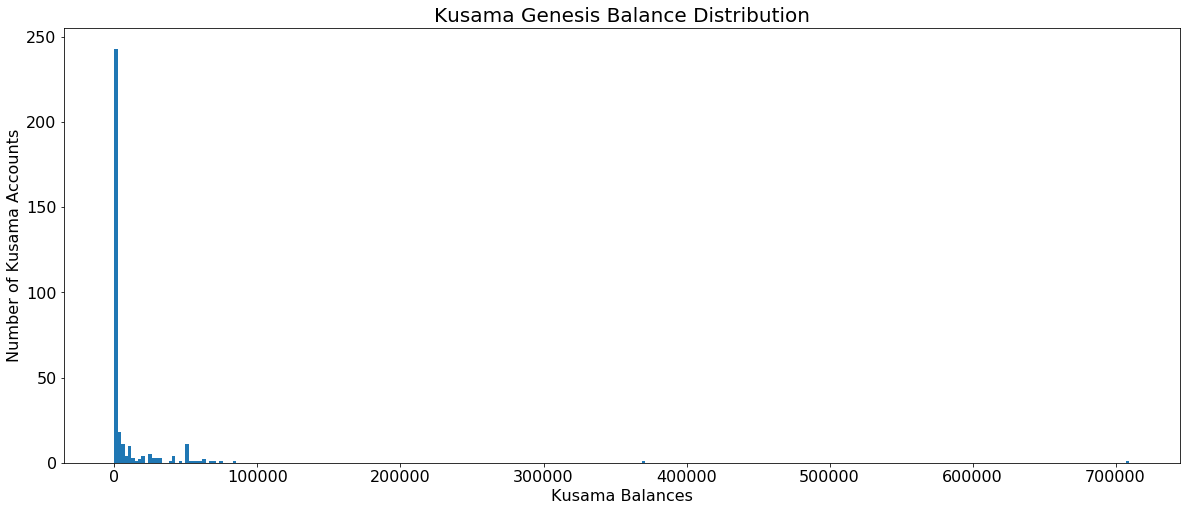

In [6]:
# Histogram of Kusama balances ignoring accounts with <= 0.01 KSM
plt.figure(figsize=(20,8))
plt.hist(dataClean["Balance"],300)
plt.xlabel('Kusama Balances',fontsize = 16)
plt.ylabel('Number of Kusama Accounts',fontsize = 16)
plt.title('Kusama Genesis Balance Distribution',fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.savefig('KusamaGenesisBalances.pdf')

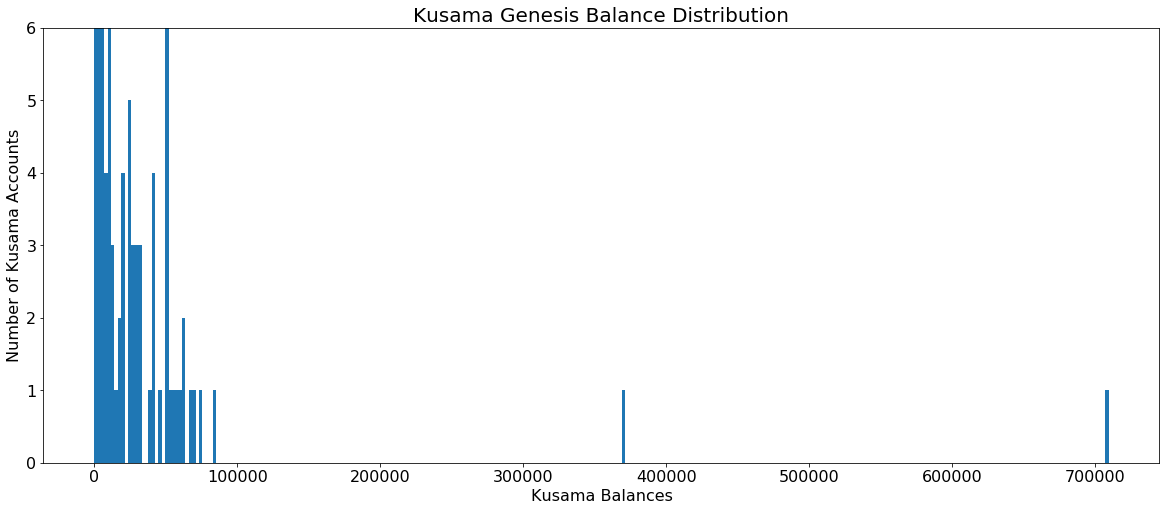

In [7]:
# Zooming into the figure
plt.figure(figsize=(20,8))
plt.hist(dataClean["Balance"],300)
plt.xlabel('Kusama Balances',fontsize = 16)
plt.ylabel('Number of Kusama Accounts',fontsize = 16)
plt.title('Kusama Genesis Balance Distribution',fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0,6])
plt.show()

In [8]:
#outlierShare
round((dataClean["Balance"][1]+dataClean["Balance"][2])*100/sumKSM,2)

12.22

We observe two outlier account balances with 709,346.898 & 369,340.969 KSM, whereas the lowest balance has 0.825 KSM. The largest two balances hold 12.22 % share of the whole Kusamas at genesis.

### 1.3. Add New Accounts

In [9]:
# Add new accounts with small balances
# Number of new accounts
N_new = 1000
# Account value in KSM
w_new = 50
# New account balances 
w_new_0 = np.multiply(w_new, np.ones((N_new)))

# 2. Initial Conditions and Parameters

### 2.1. Setting the Initial Wealth Distribution

In [10]:
# Initial wealth
#w_0 = dataClean['Balance'].values
w_0 = np.sort(np.concatenate((dataClean['Balance'].values,w_new_0)))
# Number of validators and nominators
N = w_0.shape[0]
N_v = 300
# Number of Nominators
N_n = N - N_v

### 2.2. Bootstraping a Set of Validators and Nominators

In [11]:
# Create an array of indices for all the accounts
idx_N = np.array(range(0, N)) 
# Generate random indices corresponding to the validator account balances
idx_v = np.sort(random.sample(range(0, N), N_v))
# Set the remaning indices for nominators
idx_n = np.delete(idx_N, idx_v)
# Bootstrap validators from the initial distribution
w_0_v = np.take(w_0, idx_v)
# Set the remaning accounts as nominators
w_0_n = np.take(w_0, idx_n)

### 2.3. Parameters

In [12]:
# Fraction of stakes from the Kusama genesis balances
f_0 = 0.5
# Initial validator staking
d_0_v = f_0*w_0_v
# Initial nominator staking
d_0_n = f_0*w_0_n
# Inflation parameters
I_0 = 0.025 
chi_ideal = 0.5
r_ideal = 0.2
d_shift = 0.05
# Total time length
year = 20
T = 365*year
# Annual opportunity cost of capital
R_opp = 0.05
# Staking adjustment speed
alpha = 100
# Staking stickiness parameter: update roughly once a week
p_s = 1/7
# Unresponsiveness parameter: occurs roughly once every other week
p_u = 1/14
# Equivocation parameter: occurs roughly once every other month
p_e = 1/60
# Commission fee fraction charged by validators
fee_v = 0.2

### 2.4. Assigning Validators to Nominators Randomly

In [13]:
# Assign nominators to validators randomly by allowing assignment to the same validators using replace=True 
# since N_n > N_v and store them into an index vector A_v 
A_v = np.random.choice(idx_v, N_n, replace=True, p=None)

# 3. Function Definitions

## 3.1. Inflation and Interest Rates 

In [14]:
# Annual inflation rate as a function of the staking rate x
# ->Input parameters:
# I_0: inflation 
# chi_ideal: ideal staking rate
# r_ideal: ideal interest rate
# d_shift: shift parameter
# Input variable:
# x: staking rate as a number
# Output->:
# annualInflation: annual inflation rate
def annualInflation(I_0, chi_ideal, r_ideal, d_shift, x):
    if 0 <= x <= chi_ideal:
        I = I_0 + (r_ideal - I_0/chi_ideal)*x
    if chi_ideal < x <= 1:
        I = I_0 + (r_ideal*chi_ideal - I_0)*2**((chi_ideal - x)/d_shift)
    return I

# Annual interest rate
# ->Input parameters: I_0, chi_ideal, r_ideal, dinf
# Input variable:
# x: staking rate as a number
# Output->:
# annualInterest: annual inflation rate
def annualInterest(I_0, chi_ideal, r_ideal, d_shift, x):
    if 0<= x < 0.00001:
        r = 2.62
    else:
        r = annualInflation(I_0, chi_ideal, r_ideal, d_shift, x)/x
    return r

## 3.2. Plot of Inflation and Interest Rates

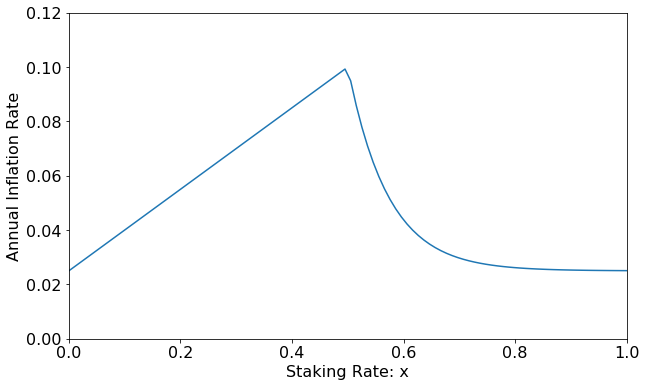

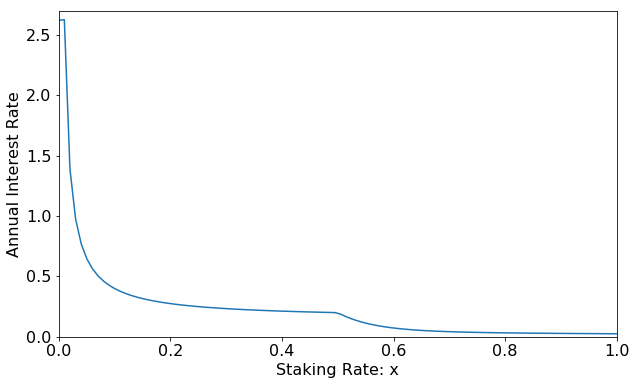

In [15]:
# Plot the annual NPoS inflation and interest rate curves
xlin = np.linspace(0, 1, 100, endpoint=True)
Ilin = np.zeros(len(xlin))
rlin = np.zeros(len(xlin))
for i in range(0,len(xlin)):
    Ilin[i] = annualInflation(I_0, chi_ideal, r_ideal, d_shift, xlin[i])
    rlin[i] = annualInterest(I_0, chi_ideal, r_ideal, d_shift, xlin[i])

plt.figure(figsize=(10,6))
plt.plot(xlin, Ilin)
plt.xlabel('Staking Rate: x',fontsize=16)
plt.ylabel('Annual Inflation Rate',fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
axes = plt.gca()
axes.set_ylim([0,0.12])
axes.set_xlim([0,1])
plt.show()

plt.figure(figsize=(10,6))
plt.plot(xlin, rlin)
plt.xlabel('Staking Rate: x',fontsize=16)
plt.ylabel('Annual Interest Rate',fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
axes = plt.gca()
axes.set_ylim([0,2.7])
axes.set_xlim([0,1])
plt.show()

## 3.2. NPoS Economic Model

In [16]:
# NPoSEcononomics function calculates nominal wealth, staking process of nominators and validators where validators 
# are randomly assigned to these nominators. It calculates staking, inflation and interest rates in each era t.

# TO DO!!!
# Each sub calculation is to be written as functions to have a cleaner and more readable code.

def NPoSEcononomics(I_0, chi_ideal, r_ideal, d_shift, w_0_n, w_0_v, d_0_n, d_0_v, T, R_opp, alpha, p_s, p_u, p_e, fee_v): 
    
    # Number of Nominators and validators
    N_n = w_0_n.size
    N_v = w_0_v.size
    # Pre-allocate w, d, I, r, x matrices
    # Nominal wealth of nominators and validators
    w_n = np.zeros((T+1,N_n))
    w_v = np.zeros((T+1,N_v))
    # Nominator, validator & total stakes backing the same validators
    d_n = np.zeros((T+1,N_n))
    d_v = np.zeros((T+1,N_v))
    d_v_tot = np.zeros((T+1,N_v))
    d_v_sub = np.zeros((T+1,N_v))
    # Total payouts, payouts to validators and nominators
    p = np.zeros((T+1,N_v))
    p_v = np.zeros((T+1,N_v))
    p_n = np.zeros((T+1,N_n))
    # Inflation rate
    I = np.zeros((T+1,1))
    # Interest rate
    r = np.zeros((T+1,1))
    # Staking rate
    x = np.zeros((T+1,1))
    # Unit vectors of size equal to the number of nominators and validators
    idN_n = np.ones((1,N_n))
    idN_v = np.ones((1,N_v))
    # Vectors of zeros of size equal to the number of nominators and validators
    zeroN_n = np.zeros((1,N_n))
    zeroN_v = np.zeros((1,N_v))
    # Nominator and validator slashing
    s_n = np.zeros((T+1,N_n))
    s_v = np.zeros((T+1,N_v))

    # Set initial values
    w_n[0,:] = w_0_n
    w_v[0,:] = w_0_v
    d_n[0,:] = d_0_n
    d_v[0,:] = d_0_v
    x[0] = (np.sum(d_0_n) + np.sum(d_0_v))/(np.sum(w_0_n) + np.sum(w_0_v))
    I[0] = annualInflation(I_0, chi_ideal, r_ideal, d_shift, x[0])
    r[0] = annualInterest(I_0, chi_ideal, r_ideal, d_shift, x[0])
    
    # Update values of these matrices in time
    t = 1
    while t <= T:
        # Unresponsiveness process determined by a Bernoulli variable with probability p_u
        u = np.random.binomial(1, p_u,N_v)
        # Number of unresponsiveness per era
        k_u = np.sum(u)
        # Slashing fraction for unresponsiveness
        f_u = 0.05*min((3*(k_u-1)/N_v),1)
        
        # Equivocation process determined by a Bernoulli variable with probability p_e
        e = np.random.binomial(1, p_e,N_v)
        # Number of unresponsiveness per era
        k_e = np.sum(e)
        # Slashing fraction for unresponsiveness
        f_e = min(((3*k_e/N_v)**2),1)
        
        # Slashing validators at time t-1
        s_v[t-1,:] = np.multiply(u*f_u + e*f_e,d_v[t-1,:])
        # No slashing at genesis
        s_v[0,:] = np.zeros((1,N_v))
        
        # Calculate payouts
        for i in range(0,idx_v.size):
            
            # The indices of nominators backing the validator with index i
            n_v = np.where(A_v == idx_v[i])
            n_v = n_v[0]
            j = 0
            d_v_sub[t-1,i] = 0
            while j <= len(n_v)-1:
                # Total stake also gets a contribution from nominators backing validator i
                d_v_sub[t-1,i] = d_v_sub[t-1,i] + d_n[t-1,n_v[j]]
                # Switch to the next nominator
                j = j + 1
            # Total stake gets a self stake contribution from validator i itself and nominators backing it
            d_v_tot[t-1,i] = d_v[t-1,i] + d_v_sub[t-1,i]  
            
            # Total payout to validator i and its nominators
            p[t,i] = d_v_tot[t-1,i]*(r[t-1]/365)
            
            # Payout of validator i including the commission fee 
            p_v[t,i] = p[t,i]*fee_v + (d_v[t-1,i]/d_v_tot[t-1,i])*p[t,i]*(1-fee_v)
            
            # Payout of nominators backing validator i net of the validator fee
            for k in range(0,len(n_v)):
                # Nominator n_v[k]'s payout backing validator i
                p_n[t,n_v[k]] = (d_n[t-1,n_v[k]]/d_v_tot[t-1,i])*p[t,i]*(1-fee_v)
                # Slash nominators if their validator is slashed
                #u = u[0] # get rid of extra []
                #e = e[0] # get rid of extra []
                s_n[t-1,n_v[k]] = np.multiply((u[i]*f_u + e[i]*f_e),d_n[t-1,n_v[k]])
        
        # No slashing of nominators at genesis
        s_n[0,:] = np.zeros((1,N_n))
        
        # Calculate the wealth at time t 
        w_n[t,:] = w_n[t-1,:] + p_n[t,:] - s_n[t-1,:]
        w_v[t,:] = w_v[t-1,:] + p_v[t,:] - s_v[t-1,:]
        # Set wealth to zero if it has less than 0.01 KSM
        for i in range(0,N_n):
            if w_n[t,i] <= 0.01:
                w_n[t,i] = 0
        for i in range(0,N_v):
            if w_v[t,i] <= 0.01:
                w_v[t,i] = 0
        
        # Staking decision stickiness process determined by a Bernoulli variable with probability p_s
        update_n = np.random.binomial(1, p_s,(1,N_n))
        update_v = np.random.binomial(1, p_s,(1,N_v))
        # Update the stake based on the comparison of the interest rate with the opportunity cost of capital
        d_n[t,:] = d_n[t-1,:] + alpha*np.multiply(update_n,np.multiply(w_n[t,:],(r[t-1]/365 - (R_opp/365)*idN_n)))
        d_v[t,:] = d_v[t-1,:] + alpha*np.multiply(update_v,np.multiply(w_v[t,:],(r[t-1]/365 - (R_opp/365)*idN_v)))
        # Boundary conditions for d_n
        for i in range(0,N_n):
            if np.sign(d_n[t,i]) == -1:
                d_n[t,i] = 0
            if np.sign(d_n[t,i] - w_n[t,i]) == 1:
                d_n[t,i] = w_n[t,i]
            if w_n[t,i] == 0:
                d_n[t,i] = 0
        # Boundary conditions for d_v
        for i in range(0,N_v):
            if np.sign(d_v[t,i]) == -1:
                d_v[t,i] = 0
            if np.sign(d_v[t,i] - w_v[t,i]) == 1:
                d_v[t,i] = w_v[t,i]
            if w_v[t,i] == 0:
                d_v[t,i] = 0
        
        # Calculate the staking rate
        x[t] = (np.sum(d_n[t,:])+ np.sum(d_v[t,:]))/(np.sum(w_n[t,:]) + np.sum(w_v[t,:]))
        
        # Calculate the inflation & interest rates
        I[t] = annualInflation(I_0, chi_ideal, r_ideal, d_shift, x[t])
        r[t] = annualInterest(I_0, chi_ideal, r_ideal, d_shift, x[t])
        
        # Switch to the next time step
        t = t + 1
    return w_n, w_v, d_v_tot, x, I, r

In [17]:
# Run the NPoSEconomics function
M = NPoSEcononomics(I_0, chi_ideal, r_ideal, d_shift, w_0_n, w_0_v, d_0_n, d_0_v, T, R_opp, alpha, p_s, 0, 0, fee_v)
# Save the output
w_n = M[0]
w_v = M[1]
d_v_tot = M[2]
x = M[3]
I = M[4]
r = M[5]
t = np.linspace(0, T, T+1)
# Merge wealth vectors of nominators and validators
w = np.sort(np.concatenate((w_n,w_v),axis=1))

## 3.3. Gini Coefficient of Wealth Inequality

In [18]:
# Calculate the time series of the Gini coffecient in order to observe the evolution of 
# the inequality of wealth among nominators
# ->Input parameter:
# wealth: t x n time series of matrix of the wealth of nominators 
# <-Output: 
# G: The time series of the Gini coefficient
def Gini(wealth):
    # Calculate the number of time periods
    N_t = wealth.shape[0]
    # Calculate the number of nominators and validators
    N = wealth.shape[1]
    # Preallocate the Gini coefficient time series vector
    G = np.zeros((N_t,1))
    # Calculate Gini coefficient for each time t
    for i in range(0,wealth.shape[0]):
        # Order wealth in ascending order
        wealth[i,:] = np.sort(wealth[i,:])
        # Calculate the rank
        rank = np.arange(1,wealth[i,:].shape[0]+1)
        G[i] = (np.sum((2*rank - N -1)*wealth[i,:]))/(N*np.sum(wealth[i,:]))
    return G

In [19]:
# Calculate the time series of the Gini Coefficient
G = Gini(w)

## 3.4 Import Data from Previous Versions

In [20]:
x_v3 = np.loadtxt("x_v3.csv", delimiter=",")
x1 = x_v3[:,0]
x2 = x_v3[:,1]
x3 = x_v3[:,2]
r_v3 = np.loadtxt("r_v3.csv", delimiter=",")
r1 = r_v3[:,0]
r2 = r_v3[:,1]
r3 = r_v3[:,2]
G_v3 = np.loadtxt("G_v3.csv", delimiter=",")
G1 = G_v3[:,0]
G2 = G_v3[:,1]
G3 = G_v3[:,2]

In [21]:
# Export Data
x_v4 = np.concatenate((x_v3,x),axis=1)
r_v4 = np.concatenate((r_v3,r),axis=1) 
G_v4 = np.concatenate((G_v3,G),axis=1) 
np.savetxt("x_v4.csv", x_v4, delimiter=",")
np.savetxt("r_v4.csv", r_v4, delimiter=",")
np.savetxt("G_v4.csv", G_v4, delimiter=",")

## 3.5. Summary Plots

In [22]:
# summaryPlots function produces the time series plots of the staking rate, interest rate and Gini coefficient
def summaryPlots(t, x, r, G, x1, x2, x3, r1, r2, r3, G1, G2, G3):
#def summaryPlots(t, x, r, G):
    version = ['V1', 'V2', 'V3', 'V4']
    plot_titles = ['Staking Rate', 'Annual Interest Rate', 'Gini Coefficient for Wealth Inequality']
    plot_variables1 = [x1, r1, G1]
    plot_variables2 = [x2, r2, G2]
    plot_variables3 = [x3, r3, G3]
    plot_variables4 = [x, r, G]
    y_labels = ['Staking Rate: x(t)','Interest Rate: r(x(t))','Gini Coefficient: G(t)']
    for i in range(0,len(plot_titles)):
        plt.figure(figsize=(12,6))
        plt.plot(t, plot_variables1[i],"-b",linestyle='-.', label="V1")
        plt.plot(t, plot_variables2[i],"-r",linestyle=':', label="V2: Staking Stickiness")
        plt.plot(t, plot_variables3[i],"-y",linestyle=':', label="V3: Stickiness & Slashing")
        plt.plot(t, plot_variables4[i],"-g",linestyle='-.', label="V4: Staking Stickiness, Slashing & Delegated Validators")
        plt.legend(loc="best",fontsize=10)
        plt.title('NPoS Economics V4: ' + plot_titles[i],fontsize=16)
        plt.xlabel('Number of Days: t',fontsize=16)
        plt.ylabel(y_labels[i],fontsize=16)
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        plt.savefig(plot_titles[i] + '.pdf')

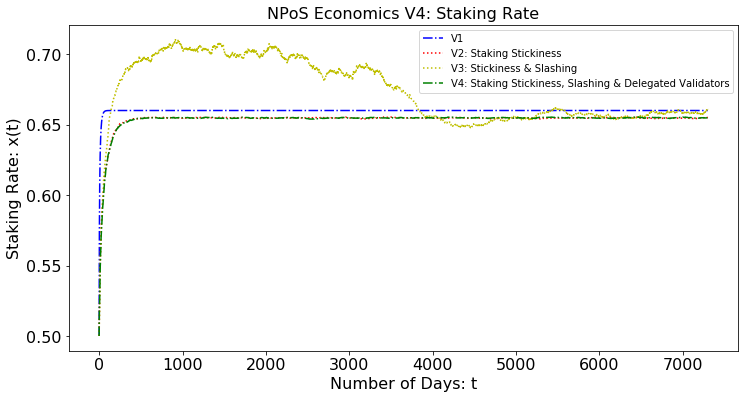

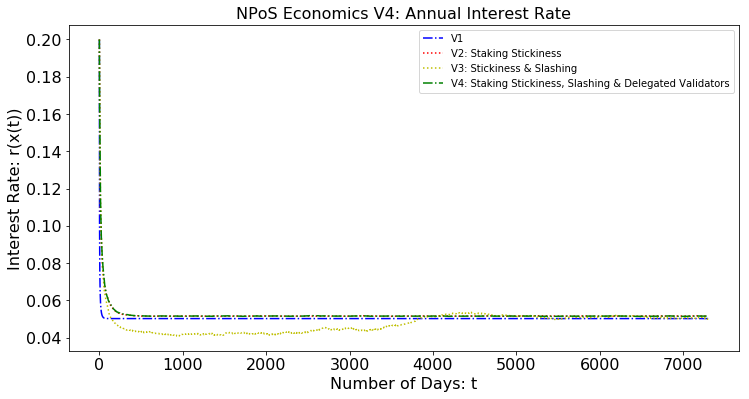

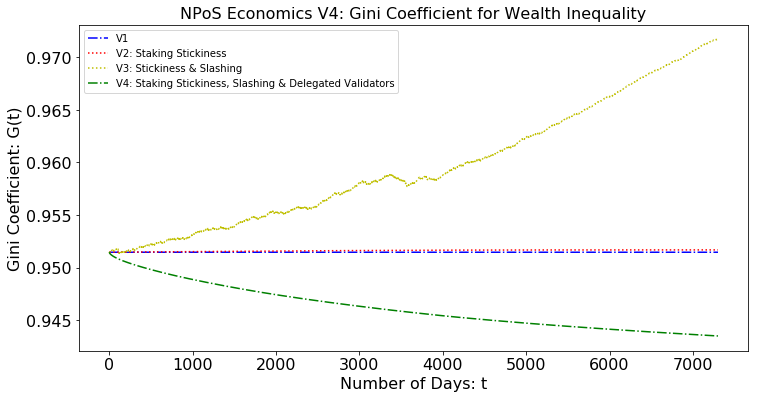

In [23]:
# Run the summary plots
summaryPlots(t, x, r, G, x1, x2, x3, r1, r2, r3, G1, G2, G3)

## Results V4
In the V4 of the model for the NPoS Economics, we study the effect of seperating validators from nominators. We randomly select a fixed set of validators from the initial acccounts, and assume that the remaning accounts are nominators. We then assign validators to these nominators randomly. The nominators keep backing the same validators all the time. Validators charge a fixed $20\%$ fee at every era, and the remaning rewards are split among the validator and the nominators backing that validator proportional to their stakes.

We assume that nominators adjust their stakes roughly once a week, where we model stickiness with a Bernoulli random variable with probability $p_s = 1/7$ to produce the desired frequency. In V3, we added slashing due to misbehaviors, namely, unresponsiveness and equivocation. We use Bernoulli random variables with probabilities $p_u = 1/14$ and $p_e = 1/60$ so that there is about one unresponsiveness in every other week and one equivocation in every other month. Once a validator is slashed, the nominators backing that validator are also slashed. We implemented a stake adjusting mechanism that depends on the difference between a nominal interest rate and an opportunity cost of capital. We use Kusama genesis account balances to set up the initial conditions for the wealth and the stakes of each nominator. We summarize our basic results below:
1. Thanks to the random selection of validators and nonzero commission fees charged by validators, we observe that the Gini coeficient decreases over time. The descrease in wealth inequality in time can be attributed to the fact that validators with small wealth have a chance to collect fees and increase their wealth, which improves the wealth inequality in time. 
2. The staking rate, $x(t)$, evolves to a steady state value fast, hence introducing independent validators and nominators improves the efficieny in the NPoS economy. We tested it with 20 years of run, and observe that staking rate reaches the steady state value of $x_{\rm steady state} \approx 0.66$ in the long run. In the short run, however, it remains stable around the value slightly above $x_{\rm steady state} \approx 0.655$. 
3. When a nominator is slashed, the staking rate decreases first, and then, the same nominator increases stakes again to achive a return above or at the opportunity cost of capital. Hence we observe a slight variation in the staking rate over time. As there are always some slashings, the staking rate remains above the steady state value.
4. Similar to the staking rate, interest rate reaches the state state value $r_{\rm steady~state} = 0.051$ in the long run ($T\sim 20$ years), and remains slightly above "market" value $R_{\rm opp} = 0.05$. Therefore, with the current set of parameters, the NPoS economy remains slightly competitive compared to the market.  
4. To summarize the effects of introducing independent validators and nominators
    - The staking rate reaches to its steady state value quickly and remains stable over time. 
    - The wealth inequality decreases over time thanks to giving fair chance to validators by randomly choosing them.
    - We expect the wealth inequality to decrease even further when we relax the assumption that validators are selected once in the beginning, and instead introduce validator selection in every era. This way more validators with small wealth can have a chance to increase their wealth, and hence contribute to decreasing the wealth inequality. This is to be studied in the next version of the model.